In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Non-private data processing

In [2]:
# Read in the original data
adult_cols = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital', 
              'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
              'hours_week', 'native_country', 'label']
adult_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_data = pd.read_csv(adult_path, skipinitialspace=True, names=adult_cols, index_col=False)
adult_data.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
workclass = { 
    -4:"Never-worked",
    -3:"Federal-gov",
    -2:"State-gov",
    -1:"Self-emp-not-inc",
    0:"Private",
    1:"Local-gov",
    2:"Self-emp-inc",
    3:"Without-pay"
}

education = {
    -8:"Preschool",
    -7:"5th-6th",
    -6:"12th",
    -5:"Prof-school",
    -4:"10th",
    -3:"11th",
    -2:"Masters",
    -1:"Some-college",
    0:"HS-grad",
    1:"Bachelors",
    2:"Assoc-voc",
    3:"Assoc-acdm",
    4:"7th-8th",
    5:"9th",
    6:"Doctorate",
    7:"1st-4th"
}

occupation = {
    -7:"Armed-Forces",
    -6:"Protective-serv",
    -5:"Farming-fishing",
    -4:"Transport-moving",
    -3:"Other-service",
    -2:"Adm-clerical",
    -1:"Craft-repair",
    0:"Prof-specialty",
    1:"Exec-managerial",
    2:"Sales",
    3:"Machine-op-inspct",
    4:"Handlers-cleaners",
    5:"Tech-support",
    6:"Priv-house-serv"
}

relationship = {
    -3:"Other-relative",
    -2:"Unmarried",
    -1:"Not-in-family",
    0:"Husband",
    1:"Own-child",
    2:"Wife"
}

race = {
    -2:"Amer-Indian-Eskimo",
    -1:"Black",
    0:"White",
    1:"Asian-Pac-Islander",
    2:"Other"
}

sex = {
    0:"Female",
    1:"Male"
}

label = {
    0:"<=50K", 
    1: ">50K"
}

In [4]:
def process_adult(df):

    # Remove fnlwgt and native_country column 
    df = df.drop(["fnlwgt", "native_country", "capital_gain", "capital_loss", "marital"], axis=1)
    
    # Remove missing values
    df = df[~df.eq("?").any(1)]
    
    # Encode the categorical features
    categorical_features = ["workclass", "education", "occupation", "relationship", "race"]
    df["workclass"] = df["workclass"].map({v: k for k, v in workclass.items()})
    df["education"] = df["education"].map({v: k for k, v in education.items()})
    df["occupation"] = df["occupation"].map({v: k for k, v in occupation.items()})
    df["relationship"] = df["relationship"].map({v: k for k, v in relationship.items()})
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    
    # Keep separate variabels with labels of outcome + protected classes for downstream plots, tables, etc
    df["gender_labs"] = df["sex"]
    df["over_under_50k"] = df["label"]
    
    # Map binary features to 0/1
    df["sex"] = df["sex"].map({"Female":0, "Male":1})
    df["label"] = df["label"].map({"<=50K":0, ">50K":1})

    return df

In [5]:
# Get the processed adult data
processed_adult = process_adult(adult_data)

In [6]:
# Split processed data into train and test
non_priv_data = processed_adult.drop(["gender_labs", "over_under_50k"], axis=1)
non_priv_train, non_priv_test = train_test_split(non_priv_data, test_size=0.2, random_state=0)
non_priv_train = non_priv_train.reset_index(drop=True)
non_priv_train

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label
0,24,0,1,13,-2,2,0,0,50,0
1,50,0,-2,14,0,-3,0,1,60,0
2,41,1,-1,10,-2,2,-1,0,40,0
3,39,0,0,9,3,-1,-1,1,40,0
4,46,0,0,9,-3,0,0,1,50,0
...,...,...,...,...,...,...,...,...,...,...
24569,55,0,1,13,3,-2,0,0,40,0
24570,50,2,-1,10,1,-2,0,0,75,0
24571,27,0,2,11,3,-1,0,1,40,0
24572,28,1,-1,10,1,0,0,1,65,0


In [7]:
def get_classification_summary(train_df, test_df, classifier="forest", evaluate="test", feature_importance=False):
    
    # Train the classification model
    X_train, y_train = train_df.drop("label", axis=1), train_df["label"]
    X_test, y_test = test_df.drop("label", axis=1), test_df["label"]
    if classifier == "logistic":
        m = LogisticRegression(max_iter=1000, C=1., penalty="l2")
        m.fit(X_train, y_train)
    elif classifier == "forest":
        m = RandomForestClassifier(random_state=0)
        m.fit(X_train, y_train)
    else:
        raise Exception(f"Classifier {classifier} not recognized.")
        
    # Get features importances
    if feature_importance:
        features = train_df.columns
        if classifier == "logistic":
            importances = np.abs(m.coef_)[0]
        elif classifier == "forest":
            importances = m.feature_importances_
        sorted_coef_idx = np.argsort(importances)[::-1]
        sorted_coef = importances[sorted_coef_idx]
        sorted_features = features[sorted_coef_idx]
        print("FEATURE IMPORTANCE:\n")
        for feature, coef in zip(sorted_features, sorted_coef):
            print(f"Feature: {feature}, Impor: {coef}")
            
    # Predict on the train and test data
    y_train_pred = m.predict(X_train)
    y_test_pred = m.predict(X_test)
    
    # Get the all classification metrics
    if evaluate == "test":
        df = X_test.copy()
        df["y"] = y_test
        df["y_pred"] = y_test_pred
    else:
        df = X_train.copy()
        df["y"] = y_train
        df["y_pred"] = y_train_pred
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)
    TPR_diff = TPR_m - TPR_f
    FPR_diff = FPR_m - FPR_f
    ACC_f = (TP_f + TN_f) / sum([TP_f, FP_f, TN_f, FN_f])
    ACC_m = (TP_m + TN_m) / sum([TP_m, FP_m, TN_m, FN_m])
    F1_score = (TP_f+TP_m) / (TP_f+TP_m + 0.5*(FP_f+FP_m + FN_f+FN_m))
    
    # Print out results
    print(f"\nCLASSIFICATION RESULTS ({classifier}, eval on test data)\n")
    print("True positive rates:")
    print(f"Female: {TPR_f:.4f}, Male: {TPR_m:.4f}\n")
    print("False positive rates:")
    print(f"Female: {FPR_f:.4f}, Male: {FPR_m:.4f}\n")
    print("Equalized odds distances:")
    print(f"y=1: {TPR_diff:.4f}, y=0: {FPR_diff:.4f}\n")
    print("Classification accuracies:")
    print(f"Female: {ACC_f:.4f}, Male: {ACC_m:.4f}\n")
    print(f"F1-score: {F1_score:.4f}\n")
    
    return y_train_pred, y_test_pred

In [8]:
def plot_distributions(df, title):
    continuous = ["age", "education_num", "hours_week"]
    categorical_labels = {"workclass": workclass, "education": education, 
                          "occupation": occupation, "relationship": relationship, 
                          "race": race, "sex": sex, "label": label}
    fig, ax = plt.subplots(2, 5, figsize=(20,8))
    ax = ax.ravel()
    for i, col in enumerate(df.columns):
        if col in continuous:
            sns.histplot(data=df, x=col, hue="label", multiple="stack", ax=ax[i], discrete=True)
        else:
            labels = categorical_labels[col]
            g = sns.histplot(data=df, x=col, hue="label", multiple="stack", ax=ax[i], discrete=True)
            g.set_xticks(list(labels.keys()))
            g.set_xticklabels(labels.values(), rotation=45)
    fig.suptitle(title, size=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [9]:
data_dir = "synthetic_data/adult/"

# 2. Non-private data distributions

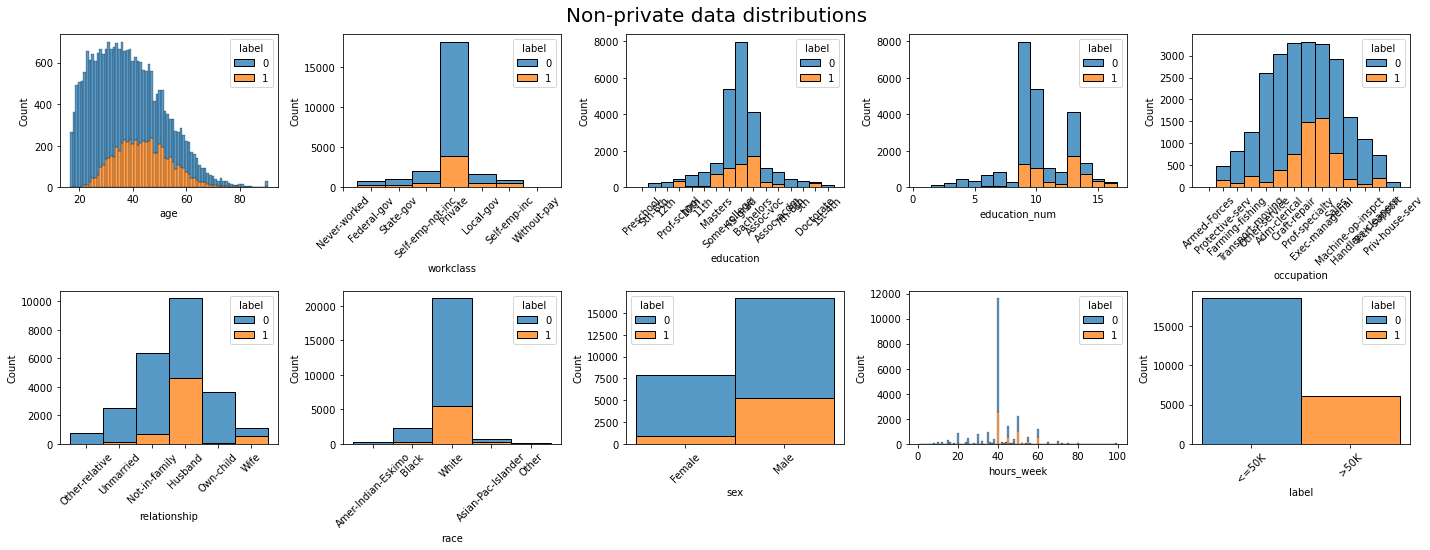

In [10]:
# Plot the non-private distributions
plot_distributions(non_priv_train, title="Non-private data distributions")

In [11]:
y_train_pred, y_test_pred = get_classification_summary(non_priv_train, non_priv_test, classifier="logistic", feature_importance=True)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")

FEATURE IMPORTANCE:

Feature: sex, Impor: 1.1955984362862684
Feature: relationship, Impor: 0.718039835013533
Feature: education_num, Impor: 0.3596223516912024
Feature: race, Impor: 0.09169001973781685
Feature: occupation, Impor: 0.06439520816432358
Feature: age, Impor: 0.054792324171083664
Feature: workclass, Impor: 0.047331355628680905
Feature: hours_week, Impor: 0.03982395178876229
Feature: education, Impor: 0.021297265014186502

CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.2338, Male: 0.5019

False positive rates:
Female: 0.0173, Male: 0.1127

Equalized odds distances:
y=1: 0.2681, y=0: 0.0954

Classification accuracies:
Female: 0.8971, Male: 0.7640

F1-score: 0.5480

Avg train pred: 0.1671, Avg test pred: 0.1730


In [12]:
y_train_pred, y_test_pred = get_classification_summary(non_priv_train, non_priv_test, feature_importance=True)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")

FEATURE IMPORTANCE:

Feature: age, Impor: 0.3060494374737465
Feature: relationship, Impor: 0.15067221234453368
Feature: hours_week, Impor: 0.1429056582834323
Feature: education_num, Impor: 0.12921002798588205
Feature: occupation, Impor: 0.12020100875369522
Feature: workclass, Impor: 0.06631247750335299
Feature: education, Impor: 0.03212951617738944
Feature: race, Impor: 0.029205511211003135
Feature: sex, Impor: 0.02331415026696464

CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.4632, Male: 0.5967

False positive rates:
Female: 0.0369, Male: 0.1434

Equalized odds distances:
y=1: 0.1335, y=0: 0.1065

Classification accuracies:
Female: 0.9060, Male: 0.7735

F1-score: 0.6140

Avg train pred: 0.2437, Avg test pred: 0.2217


# 3. MWEM data distributions

Across all trials ane epsilon values, MWEM tends to equalize both the proportion of male and female and their success rates in the synthetic data set. This leads to generally improved fairness but reduced classification accuracaies.

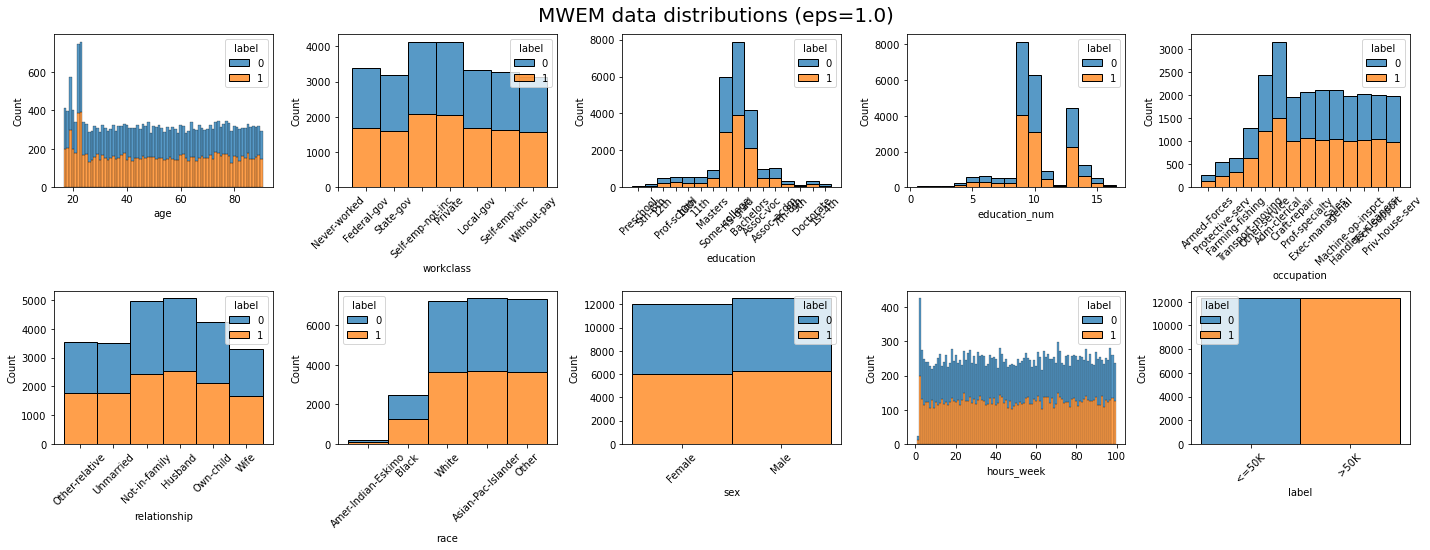

In [13]:
MWEM_eps1_rep1 = pd.read_csv(data_dir+"MWEM_eps=1.0_rep=1.csv", index_col=0)
plot_distributions(MWEM_eps1_rep1, title="MWEM data distributions (eps=1.0)")

In [14]:
y_train_pred, y_test_pred = get_classification_summary(MWEM_eps1_rep1, non_priv_test)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.4329, Male: 0.5974

False positive rates:
Female: 0.4257, Male: 0.5153

Equalized odds distances:
y=1: 0.1645, y=0: 0.0896

Classification accuracies:
Female: 0.5581, Male: 0.5207

F1-score: 0.3823

Avg train pred: 0.5000, Avg test pred: 0.5037


# 4. DP-CTGAN data distributions

Across all trials and epsilon, DP-CTGAN tends to produce synthetic data with a single label (0 or 1). In both cases, this causes the classification model to always predict either 0 or 1 making the TPR/FPR for male and female all either 0 or 1. This appears to produce very fair results, but clearly the synthetic data has of low utility. Ocassionally, however, the results appear to be more reasonable, as shown in the third example below.

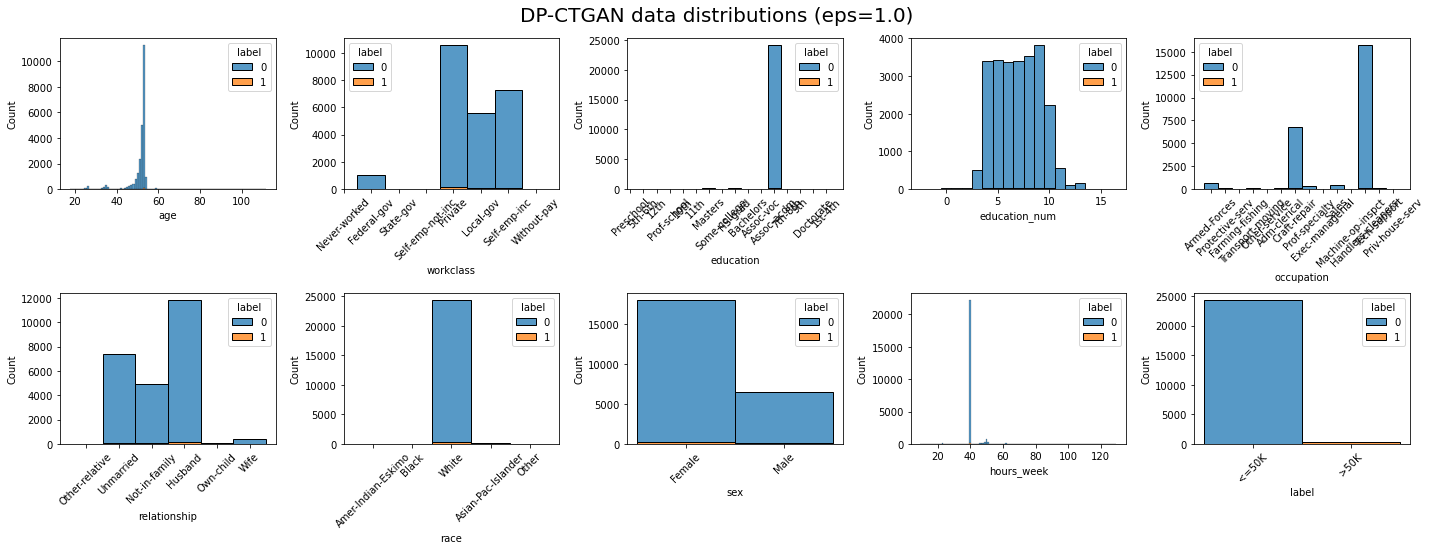

In [15]:
DPCTGAN_eps1_rep9 = pd.read_csv(data_dir+"DPCTGAN_eps=1.0_rep=9.csv", index_col=0)
plot_distributions(DPCTGAN_eps1_rep9, title="DP-CTGAN data distributions (eps=1.0)")

In [16]:
y_train_pred, y_test_pred = get_classification_summary(DPCTGAN_eps1_rep9, non_priv_test)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.0000, Male: 0.0000

False positive rates:
Female: 0.0006, Male: 0.0000

Equalized odds distances:
y=1: 0.0000, y=0: -0.0006

Classification accuracies:
Female: 0.8852, Male: 0.6801

F1-score: 0.0000

Avg train pred: 0.0027, Avg test pred: 0.0002


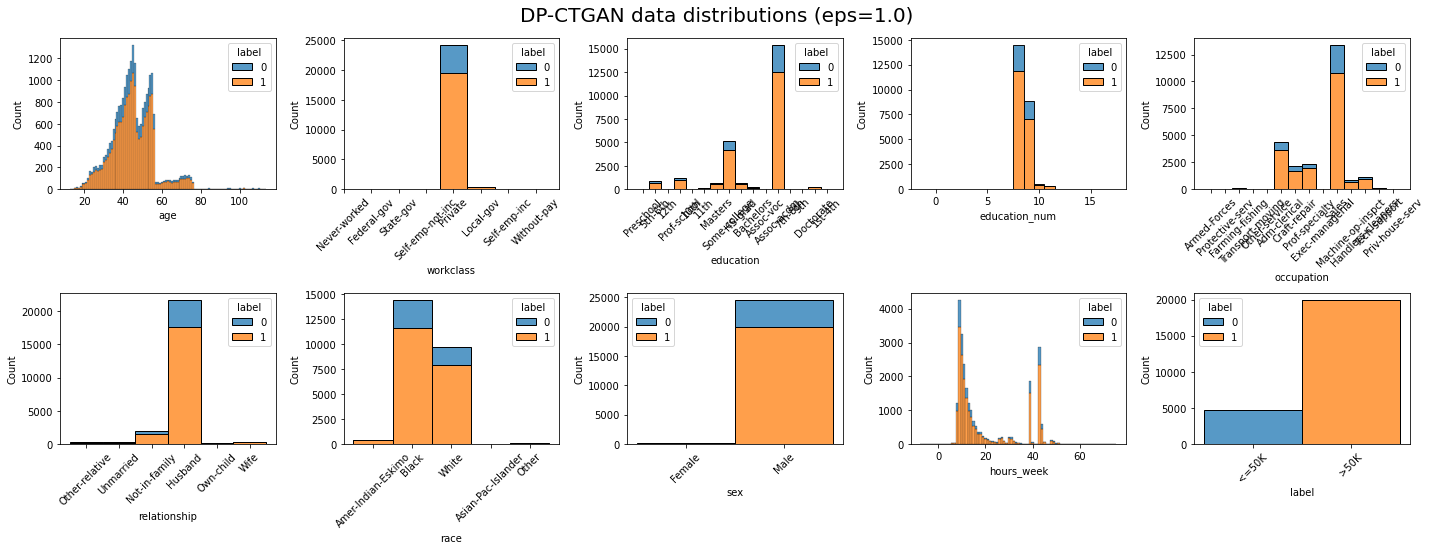

In [17]:
DPCTGAN_eps1_rep1 = pd.read_csv(data_dir+"DPCTGAN_eps=1.0_rep=1.csv", index_col=0)
plot_distributions(DPCTGAN_eps1_rep1, title="DP-CTGAN data distributions (eps=1.0)")

In [18]:
y_train_pred, y_test_pred = get_classification_summary(DPCTGAN_eps1_rep1, non_priv_test)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.9610, Male: 0.9477

False positive rates:
Female: 0.9855, Male: 0.9265

Equalized odds distances:
y=1: -0.0134, y=0: -0.0589

Classification accuracies:
Female: 0.1227, Male: 0.3531

F1-score: 0.3987

Avg train pred: 0.8682, Avg test pred: 0.9495


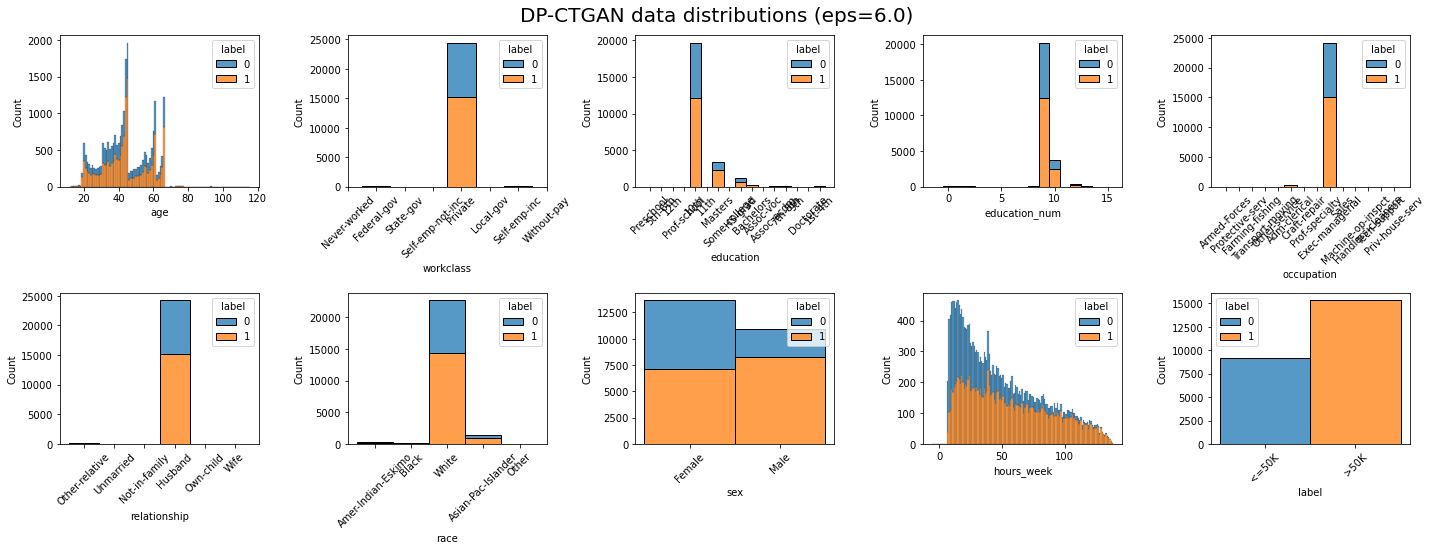

In [19]:
DPCTGAN_eps6_rep4 = pd.read_csv(data_dir+"DPCTGAN_eps=6.0_rep=4.csv", index_col=0)
plot_distributions(DPCTGAN_eps6_rep4, title="DP-CTGAN data distributions (eps=6.0)")

In [20]:
y_train_pred, y_test_pred = get_classification_summary(DPCTGAN_eps6_rep4, non_priv_test)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.7835, Male: 0.9227

False positive rates:
Female: 0.7659, Male: 0.8791

Equalized odds distances:
y=1: 0.1391, y=0: 0.1132

Classification accuracies:
Female: 0.2969, Male: 0.3774

F1-score: 0.4121

Avg train pred: 0.6381, Avg test pred: 0.8519


# 5. PATE-CTGAN data distributions

PATE-CTGAN appears to produce data with reasonable distributions that somewhat mimic those of the original, but for some reason the logistic regression classifier always predicts a label of 0. *I'm not sure why this is happening*, but a random forest classifier produces results that are much more reasonable!

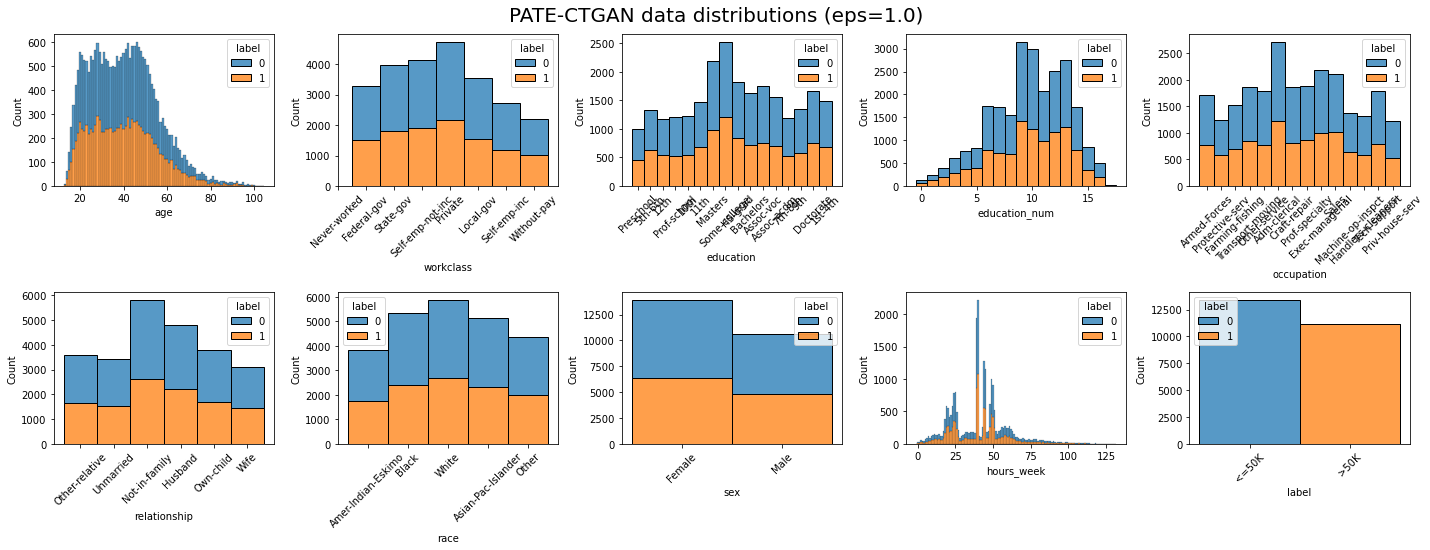

In [21]:
PATECTGAN_eps1_rep1 = pd.read_csv(data_dir+"PATECTGAN_eps=1.0_rep=1.csv", index_col=0)
plot_distributions(PATECTGAN_eps1_rep1, title="PATE-CTGAN data distributions (eps=1.0)")

In [22]:
y_train_pred, y_test_pred = get_classification_summary(PATECTGAN_eps1_rep1, non_priv_test, classifier="logistic", evaluate="test", feature_importance=False)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.0000, Male: 0.0000

False positive rates:
Female: 0.0000, Male: 0.0000

Equalized odds distances:
y=1: 0.0000, y=0: 0.0000

Classification accuracies:
Female: 0.8857, Male: 0.6801

F1-score: 0.0000

Avg train pred: 0.0000, Avg test pred: 0.0000


In [23]:
y_train_pred, y_test_pred = get_classification_summary(PATECTGAN_eps1_rep1, non_priv_test, classifier="forest", evaluate="test", feature_importance=False)
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.2857, Male: 0.4625

False positive rates:
Female: 0.2307, Male: 0.3631

Equalized odds distances:
y=1: 0.1768, y=0: 0.1323

Classification accuracies:
Female: 0.7140, Male: 0.5811

F1-score: 0.3697

Avg train pred: 0.4536, Avg test pred: 0.3429


In [40]:
def adult_classification_helper(synthesizer, eps, rep, classifier, test_df, non_priv_results=False):
    """ helper function to calculate TPR_diff, FPR_diff, and F1_score for a single synthesizer, eps, rep, and classifier """
    
    # Read in the synthetic training data or use non-private data
    if non_priv_results:
        train_df = non_priv_train
    else:
        fname = f"synthetic_data/adult/{synthesizer}_eps={eps}_rep={rep}.csv"
        train_df = pd.read_csv(fname, index_col=0)

    # Train the classification model
    X_train, y_train = train_df.drop("label", axis=1), train_df["label"]
    X_test, y_test = test_df.drop("label", axis=1), test_df["label"]
    if len(np.unique(y_train)) != 2:
        return None
    if classifier == "logistic":
        m = LogisticRegression(max_iter=1000, C=1., penalty="l2")
        m.fit(X_train, y_train)
    elif classifier == "forest":
        m = RandomForestClassifier(random_state=0)
        m.fit(X_train, y_train)
    else:
        raise Exception(f"Classifier {classifier} not recognized.")

    # Predict on the test set
    y_test_pred = m.predict(X_test)

    # Get the all classification metrics on the test set
    df = X_test.copy()
    df["y"] = y_test
    df["y_pred"] = y_test_pred
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)
    TPR_diff = TPR_m - TPR_f
    FPR_diff = FPR_m - FPR_f
    f1_score = (TP_f+TP_m) / (TP_f+TP_m + 0.5*(FP_f+FP_m + FN_f+FN_m))
    
    return (TPR_diff, FPR_diff, f1_score)

In [49]:
def get_adult_table_metrics(synthesizer, epsilon_list, nreps, classifier, test_df, f1_metric="median"):
    """ return median TPR_diff, FPR_diff, F1_score across all epsilons and repetitions """
    
    # Initialize lists
    tpr_diff_list = []
    fpr_diff_list = []
    f1_scores = []
    
    # Loop through the epsilon values and repetitions
    for eps in epsilon_list:
        for rep in range(nreps):

            # Get the classification metrics
            results = adult_classification_helper(synthesizer, eps, rep, classifier, test_df)
            if results is not None:
                TPR_diff, FPR_diff, f1_score = results
            
                # Append metrics to lists
                tpr_diff_list.append(TPR_diff)
                fpr_diff_list.append(FPR_diff)
                f1_scores.append(f1_score)
            
    # Get medians
    tpr_diff_median = np.median(tpr_diff_list)
    fpr_diff_median = np.median(fpr_diff_list)
    if f1_metric == "median":
        f1_score_metric = np.median(f1_scores)
    elif f1_metric == "max":
        f1_score_metric = np.max(f1_scores)
    
    return tpr_diff_median, fpr_diff_median, f1_score_metric

def get_adult_plot_metrics(synthesizer, epsilon_list, nreps, classifier, test_df, f1_metric="median"):
    """ return median and std of TPR_diff, FPR_diff, F1_score for *each* epsilon value (arrays of values) """
    
    # Initialize lists
    tpr_diff_median_list = []
    fpr_diff_median_list = []
    f1_score_metrics = []
    tpr_diff_std_list = []
    fpr_diff_std_list = []
    f1_score_std_list = []
    
    # Loop through the epsilon values and repetitions
    for eps in epsilon_list:
        
        # Initialize list to hold values for each epsilon value
        tpr_diff_list = []
        fpr_diff_list = []
        f1_scores = []
        
        # Loop through the range of repetitions
        for rep in range(nreps):

            # Get the classification metrics
            results = adult_classification_helper(synthesizer, eps, rep, classifier, test_df)
            if results is not None:
                TPR_diff, FPR_diff, f1_score = results
            
                # Append metrics to lists
                tpr_diff_list.append(TPR_diff)
                fpr_diff_list.append(FPR_diff)
                f1_scores.append(f1_score)
            
        # Append medians to lists
        tpr_diff_median_list.append(np.median(tpr_diff_list))
        fpr_diff_median_list.append(np.median(fpr_diff_list))
        if f1_metric == "median":
            f1_score_metrics.append(np.median(f1_scores))
        elif f1_metric == "max":
            f1_score_metrics.append(np.max(f1_scores))
        tpr_diff_std_list.append(np.std(tpr_diff_list))
        fpr_diff_std_list.append(np.std(fpr_diff_list))
        f1_score_std_list.append(np.std(f1_scores))
        
    return tpr_diff_median_list, fpr_diff_median_list, f1_score_metrics, tpr_diff_std_list, fpr_diff_std_list, f1_score_std_list
        
def get_adult_epsilon_plots(synthesizer_list, epsilon_list, nreps, classifier, test_df, f1_metric="median", non_priv_results=True):
    """ return subplot with three plots showing graphs of TPR_diff, FPR_diff, F1_score acros epsilons for each synthesizer """
    
    # Initialize subplots
    fig, ax = plt.subplots(1, 3, figsize=(16,5))
    
    # Loop through the synthesizers
    for synth in synthesizer_list:
        
        # Get all classification metrics
        tpr_diff_median_list, fpr_diff_median_list, f1_score_metrics, tpr_diff_std_list, fpr_diff_std_list, f1_score_std_list \
        =  get_adult_plot_metrics(synth, epsilon_list, nreps, classifier, test_df, f1_metric)
        
        # Plot the metrics with error bars
        ax[0].errorbar(epsilon_list, tpr_diff_median_list, tpr_diff_std_list, label=synth)
        ax[1].errorbar(epsilon_list, fpr_diff_median_list, fpr_diff_std_list, label=synth)
        ax[2].errorbar(epsilon_list, f1_score_metrics, f1_score_std_list, label=synth)
        
    # Add the non-private results to the plots
    non_priv_tpr_diff, non_priv_fpr_diff, non_priv_f1_score = adult_classification_helper(None, None, None, classifier, test_df, non_priv_results=True)
    ax[0].hlines(non_priv_tpr_diff, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
    ax[1].hlines(non_priv_fpr_diff, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
    ax[2].hlines(non_priv_f1_score, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
        
    # Plotting details
    for i in range(3):
        ax[i].set_xlabel("Privacy budget")
        ax[i].legend()
    ax[0].set_ylabel("Equalized odds distance ($y=1$)")
    ax[1].set_ylabel("Equalized odds distance ($y=0$)")
    ax[2].set_ylabel("F1-score")
    if classifier == "logistic":
        title = f"Adult classification summary (logistic regression)"
    elif classifier == "forest":
        title = f"Adult classification summary (random forest)"
    fig.suptitle(title, size=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Table results

In [26]:
# Specify list of epsilons
epsilon_list=[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0]

## MWEM (LR)

In [27]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("MWEM", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.082
FPR difference median: 0.032
F1-score median: 0.355


In [50]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("MWEM", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: 0.082
FPR difference median: 0.032
F1-score max: 0.562


## MWEM (RF)

In [28]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("MWEM", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.023
FPR difference median: 0.010
F1-score median: 0.334


In [51]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("MWEM", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: 0.023
FPR difference median: 0.010
F1-score max: 0.437


## DP-CTGAN (LR)

In [29]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("DPCTGAN", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.021


In [53]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("DPCTGAN", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score max: 0.561


## DP-CTGAN (RF)

In [30]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("DPCTGAN", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.031


In [54]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("DPCTGAN", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score max: 0.497


## PATE-CTGAN (LR)

In [31]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("PATECTGAN", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.000


In [55]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("PATECTGAN", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score max: 0.153


## PATE-CTGAN (RF)

In [32]:
# Plot the table metrics for PATECTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("PATECTGAN", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.001
F1-score median: 0.003


In [56]:
# Plot the table metrics for PATECTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("PATECTGAN", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: 0.000
FPR difference median: 0.001
F1-score max: 0.372


## QUAIL+MWEM (LR)

In [33]:
# Plot the table metrics for QUAIL+MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("QUAIL_MWEM", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.061
FPR difference median: 0.042
F1-score median: 0.271


In [57]:
# Plot the table metrics for QUAIL+MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("QUAIL_MWEM", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: -0.061
FPR difference median: 0.042
F1-score max: 0.582


## QUAIL+MWEM (RF)

In [34]:
# Plot the table metrics for QUAIL+MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("QUAIL_MWEM", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.077
FPR difference median: 0.017
F1-score median: 0.245


In [58]:
# Plot the table metrics for QUAIL+MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("QUAIL_MWEM", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: -0.077
FPR difference median: 0.017
F1-score max: 0.555


## QUAIL+DP-CTGAN (LR)

In [41]:
# Plot the table metrics for QUAIL+DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("QUAIL_DPCTGAN", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.001
FPR difference median: 0.045
F1-score median: 0.241


In [59]:
# Plot the table metrics for QUAIL+DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("QUAIL_DPCTGAN", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: -0.001
FPR difference median: 0.045
F1-score max: 0.585


## QUAIL+DP-CTGAN (RF)

In [42]:
# Plot the table metrics for QUAIL+DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("QUAIL_DPCTGAN", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.012
FPR difference median: 0.031
F1-score median: 0.245


In [60]:
# Plot the table metrics for QUAIL+DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("QUAIL_DPCTGAN", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: 0.012
FPR difference median: 0.031
F1-score max: 0.561


## QUAIL+PATE-CTGAN (LR)

In [43]:
# Plot the table metrics for QUAIL+PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("QUAIL_PATECTGAN", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.105
FPR difference median: 0.044
F1-score median: 0.287


In [61]:
# Plot the table metrics for QUAIL+PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("QUAIL_PATECTGAN", epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: -0.105
FPR difference median: 0.044
F1-score max: 0.567


## QUAIL+PATE-CTGAN (RF)

In [44]:
# Plot the table metrics for QUAIL+PATECTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_adult_table_metrics("QUAIL_PATECTGAN", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.084
FPR difference median: 0.018
F1-score median: 0.275


In [62]:
# Plot the table metrics for QUAIL+PATECTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_max = get_adult_table_metrics("QUAIL_PATECTGAN", epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, f1_metric="max")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score max: {f1_score_max:.3f}")

TPR difference median: -0.084
FPR difference median: 0.018
F1-score max: 0.559


## Trends across $\varepsilon$

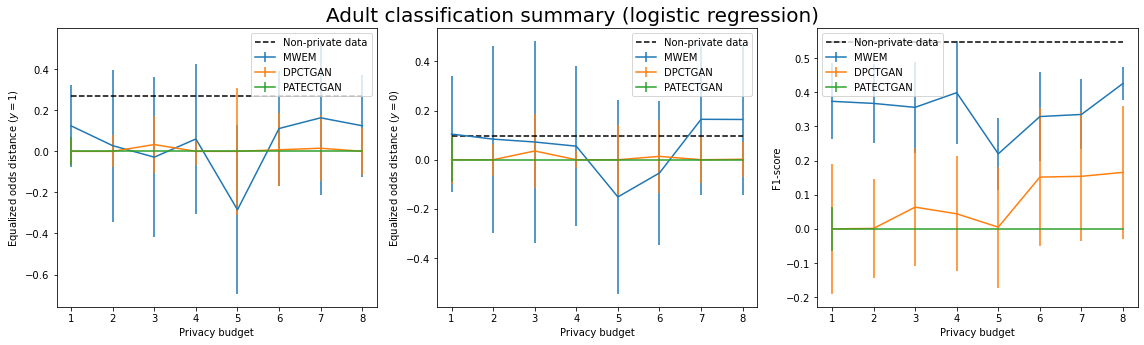

In [45]:
# Plot classification summary for logistic regression
get_adult_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, non_priv_results=True)

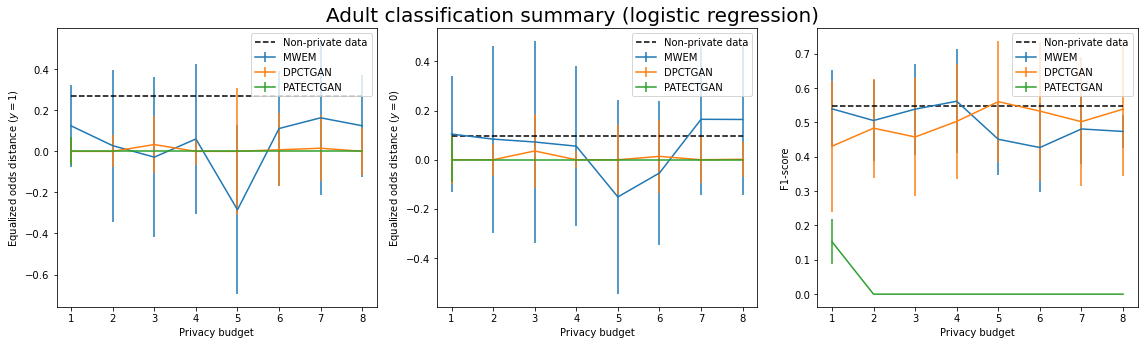

In [63]:
# Plot classification summary for logistic regression
get_adult_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, f1_metric="max", non_priv_results=True)

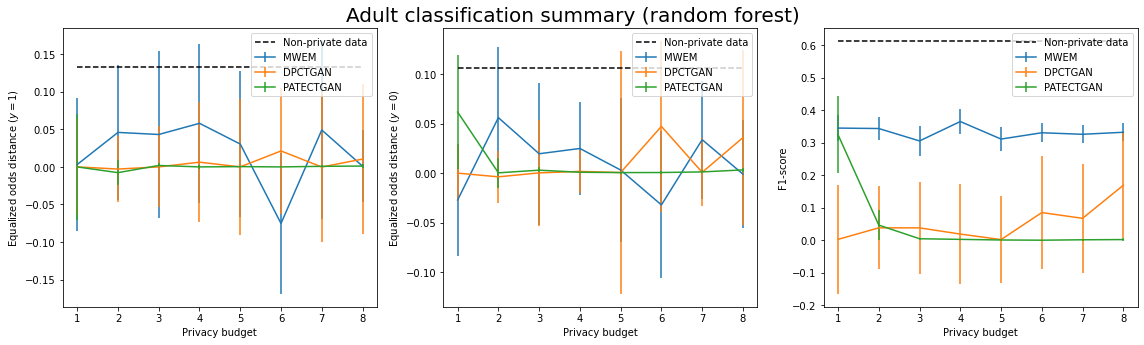

In [46]:
# Plot classification summary for random forest
get_adult_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, non_priv_results=True)

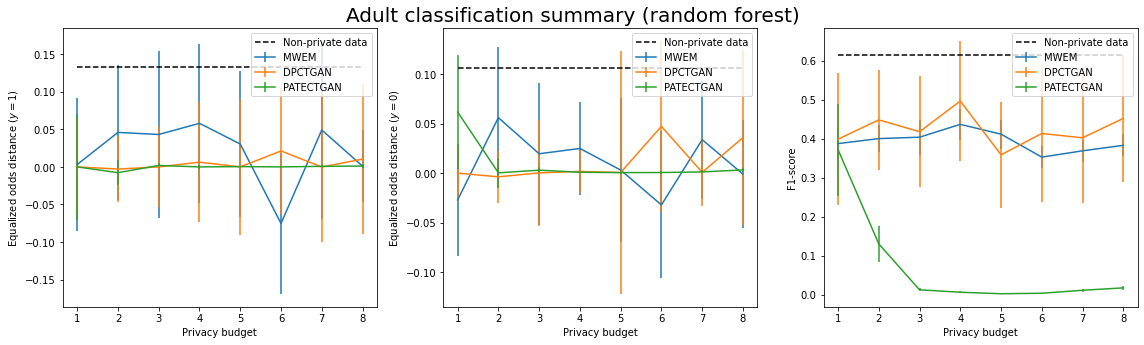

In [64]:
# Plot classification summary for random forest
get_adult_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, f1_metric="max", non_priv_results=True)

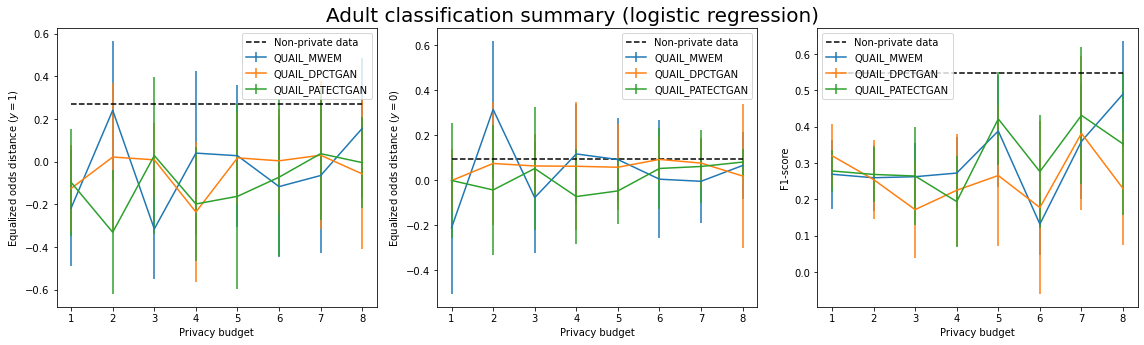

In [47]:
# Plot classification summary for logistic regression
get_adult_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, non_priv_results=True)

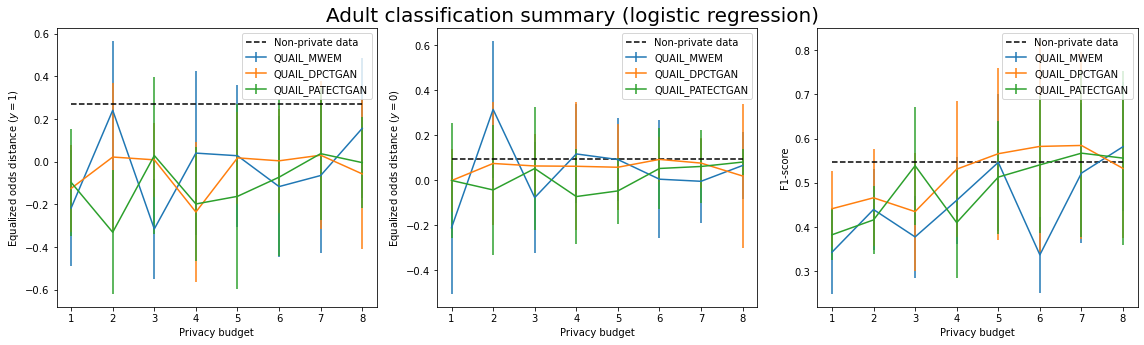

In [65]:
# Plot classification summary for logistic regression
get_adult_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_list=epsilon_list, nreps=10, classifier="logistic", test_df=non_priv_test, f1_metric="max", non_priv_results=True)

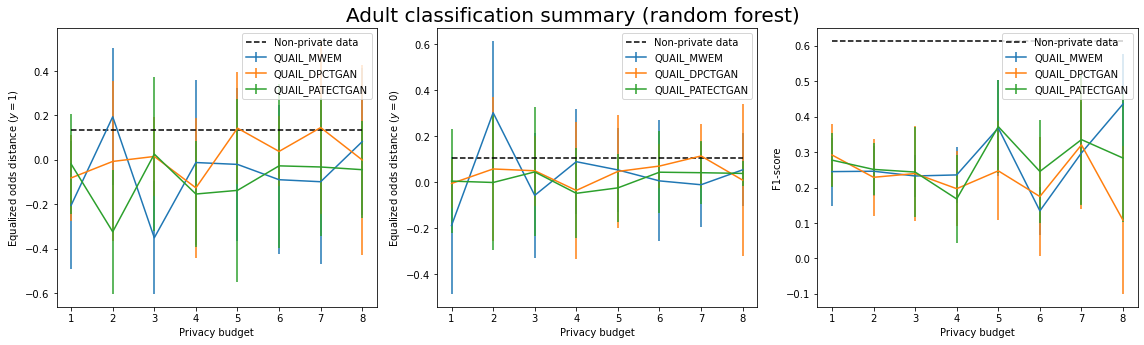

In [48]:
# Plot classification summary for random forest
get_adult_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, non_priv_results=True)

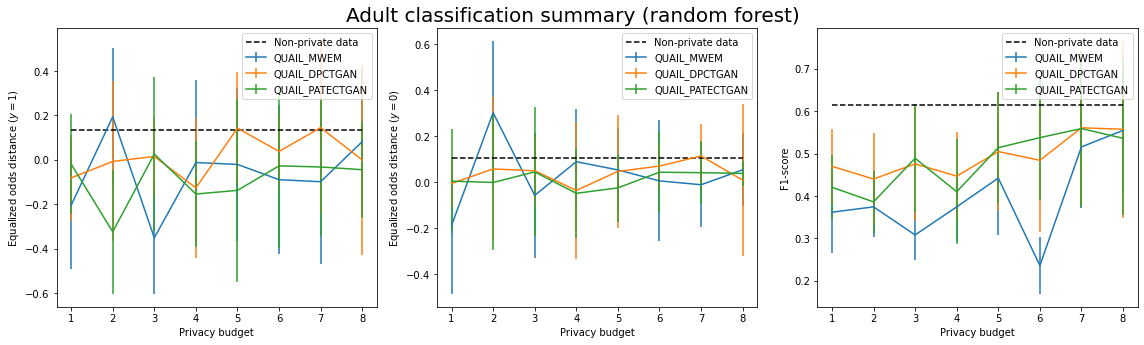

In [66]:
# Plot classification summary for random forest
get_adult_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_list=epsilon_list, nreps=10, classifier="forest", test_df=non_priv_test, f1_metric="max", non_priv_results=True)